# Exercise Set 4: controlling for observable factors and causal trees

In this Exercise Set 4 we will try out different techniques for using matching and try an implementation of causal trees. 

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from scipy.stats import ttest_rel, ttest_ind

%matplotlib inline

<br>

## 4.1 Survival and passenger class

We revisit a classic dataset: Titanic. We are interested in analyzing whether the passengers on First class had a higher survival probability. 

The code below loads the dataset. 

In [79]:
df = sns.load_dataset('titanic').dropna(subset=['age'])


X = pd.get_dummies(df.drop(['pclass','class', 'alive', 'survived'],axis=1), drop_first=True).astype('float')
D = (df['pclass'] < 3).rename('high_class')
y = (df['alive']=='yes').astype('float')

> **Ex. 4.1.1:** Compute the ATE of not travelling on a 3rd class ticket, assuming the CIA holds.

In [80]:
def basic_ATE(y, D):
    ''' Calculate ATE simply as the difference 
        in outcomes of control and treatment
        individuals.
    '''
    return y[D].mean() - y[~D].mean()

In [81]:
print(
    f'ATE: {round(basic_ATE(y,D), 3)}, with t-test of {ttest_ind(y[D], y[~D])}'
)

ATE: 0.332, with t-test of Ttest_indResult(statistic=9.569754052053101, pvalue=1.7180216268747918e-20)


> **Ex. 4.1.2:** Compute the share of males, the proportion travelling alone, and the mean age, by treatment status. Then modify the code below to try out coarsened exact matching on `exact_cols = ['age_group', 'alone','sex_male']` with age bins of size 2, 5, 10 and 15 years. 
>
> Comment on the result. Does coarse matching seem like a feasible approach in this 
```python
age_diff =  2
X['age_group'] =  (X.age // age_diff)
match_count = \
    pd.DataFrame({'treat':X[D].groupby(exact_cols).size(), 
                  'control':X[~D].groupby(exact_cols).size()})\            
n_obs_matched = int(match_count.dropna().sum().sum())
```

In [82]:
X.groupby(D)[['age','sex_male','alone']].mean().round(2)

,age,sex_male,alone
high_class,,,
False,25.14,0.71,0.63
True,34.21,0.56,0.50


In [83]:
exact_cols = ['age_group', 'alone','sex_male']

for age_diff in [2,5,10,15]:

    X['age_group'] =  (X.age // age_diff)
    match_count = pd.DataFrame(
                               {'treat':X[D].groupby(exact_cols).size(), 
                               'control':X[~D].groupby(exact_cols).size()}
                              )

    n_obs_matched = int(match_count.dropna().sum().sum())
    print(f'Number of observations matched: {n_obs_matched}, max. age difference: {age_diff}')

Number of observations matched: 611, max. age difference: 2
Number of observations matched: 662, max. age difference: 5
Number of observations matched: 679, max. age difference: 10
Number of observations matched: 687, max. age difference: 15


Continue with age difference = 5.

> **Ex. 4.1.3:** Compute the average treatment effect by using (coarsened) exact matching on `age` (i.e. on `age_group`). 
>
>Comment on the result. How does the group treatment effects compare to the ATE you found in 4.1.2?

In [84]:
from sklearn.neighbors import RadiusNeighborsRegressor

In [85]:
X['age_group'] = (X.age // 5)

exact_cols = ['age_group', 'alone','sex_male']

# We want to fit a RNR on the treatment group,
# and use it to impute the counterfactual treatment
# effect Y1 in the control group.
rnr_tgroup = RadiusNeighborsRegressor(radius = 0)
rnr_tgroup.fit(X.loc[D, exact_cols], y[D])
imputed_Y1 = rnr_tgroup.predict(X.loc[~D, exact_cols])

# Next a RNR on the control group to predict Y0 for those
# who were treated 
rnr_cgroup = RadiusNeighborsRegressor(radius = 0)
rnr_cgroup.fit(X.loc[~D, exact_cols], y[~D])
imputed_Y0 = rnr_tgroup.predict(X.loc[D, exact_cols])

# Differences
diff_treated = y[D] - imputed_Y0
diff_control = imputed_Y1 - y[~D]
diffs = np.concatenate([diff_treated, diff_control])

# Compute ATE and sd(ATE)
mu,se = np.mean(diffs[~np.isnan(diffs)]), np.std(diffs[~np.isnan(diffs)])

ci95 = '(%.3f, %.3f)' % (mu-se*1.96, mu+se*1.96)
    
print(f'ATE: {round(mu,3)}, 95% CI: {ci95}')
print('The estimate is very imprecise and we cannot reject a null. In any case it is mucher lower than the naive ATE.')

ATE: 0.109, 95% CI: (-0.703, 0.922)
The estimate is very imprecise and we cannot reject a null. In any case it is mucher lower than the naive ATE.


C:\Users\qsd161\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\neighbors\_regression.py:362: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


> **Ex. 4.1.4:** Estimate a logistic regression model for predicting the passenger class variable (i.e. `D`, the treatment indicator).

In [86]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression

lr_pipe = make_pipeline(SimpleImputer(),
                        LogisticRegression(max_iter = 1000))
lr_pipe.fit(X, D)
p = lr_pipe.predict_proba(X)

*Answer*:

- We could have used other predictive models, e.g. random forest, as the propensity score is just a predictive probability, see slides for details.
- We could have selected relevant features based on theory or optimized model out-of-sample. 

> **Ex. 4.1.6:** What is the overlap of predicted probabilities? What happens if you estimate the model without `fare` and `deck`? Comment
>
> Why do `fare` and `deck` matter a lot in this setting, try to draw a causal diagram that might illuminate your discussion.

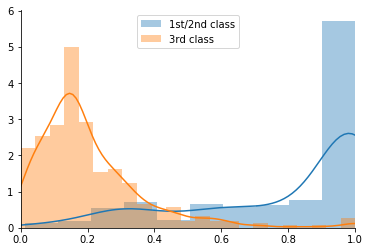

In [90]:
# overlap for model WITH fare and deck

f,ax = plt.subplots()
sns.distplot(p[D==1,1], ax=ax, label='1st/2nd class')
sns.distplot(p[D==0,1], ax=ax, label='3rd class')
ax.legend()
ax.set_xlim(0,1)
sns.despine(f)

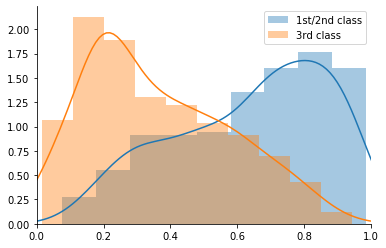

In [91]:
# overlap for model WITHOUT fare and deck

X_alt = pd.get_dummies(df.drop(['pclass','class', 'alive', 'fare', 'deck'],axis=1), drop_first=True)

lr_pipe.fit(X_alt, D)
p = lr_pipe.predict_proba(X_alt)

f,ax = plt.subplots()
sns.distplot(p[D==1,1], ax=ax, label='1st/2nd class')
sns.distplot(p[D==0,1], ax=ax, label='3rd class')
ax.legend()
ax.set_xlim(0,1)
sns.despine(f)

*Answer*: 

The overlap is almost non-existing when including fare and deck. This is because the fare and deck are (obviously) good predictors of the passengers class (remember from history lessons that 3rd class passengers were placed on the lower decks of the ship). Thus when accounting for them, the certainty of classes increases and the overlap in propensities is small. 

```
survival probability <- class -> fare, deck
                          ^
                          | 
                  other passenger traits
```


> **Ex. 4.1.7:** Use a 5-nearest-neighbors matching in propensity space to compute the average treatment effect. Bootstrap the 95 pct. confidence interval of the ATE. What happens if you select only propensity score values with high common support, i.e. between 0.2 and 0.8?

In [12]:
from sklearn.neighbors import KNeighborsRegressor

In [13]:
n_neighbors = 5

thresholds_p = [(0,1), (.2, .8)]

for threshold_lower, threshold_upper in thresholds_p:

    selection = (p[:,1] >= threshold_lower) & (p[:,1] <= threshold_upper)
    
    p_t = p[(D==1) & selection,1].reshape(-1,1)   # Propensity of treatment for the treated
    y_t = y.values[(D==1) & selection]            # Outcome for the treated
    
    p_c = p[(D==0) & selection,1].reshape(-1,1)   # Propensity for the control
    y_c = y.values[(D==0) & selection]            # Outcome for the control

    # Predict counterfactual Y1 to use for the control individuals
    psm_nn5_t = KNeighborsRegressor(n_neighbors=n_neighbors)
    psm_nn5_t.fit(p_t, y_t)
    diff_match_c = psm_nn5_t.predict(p_c) - y_c
    
    # Predict counterfactual Y0 to use with the treatment individuals
    psm_nn5_c = KNeighborsRegressor(n_neighbors=n_neighbors)
    psm_nn5_c.fit(p_c, y_c)
    diff_match_t = y_t - psm_nn5_c.predict(p_t)

    diff_match = np.concatenate([diff_match_t, diff_match_c])
    mu = diff_match.mean()
        
    print('ATE: {}'.format(round(mu,2)))


ATE: 0.01
ATE: 0.01


> **Ex. 4.1.7:** (BONUS) How might we improve on the approach above?

- We could estimate uncertainty of ATE. This could be done using inverse probabiltiy weighting and bootstrapping.
- We could have corrected for observable differences between treatment and control in age. 

## 4.2 Honest trees

In this problem we will try to implement and understand some of the ideas used in [Athey, Imbens (2015)](https://www.pnas.org/content/pnas/113/27/7353.full.pdf) to develop _Honest Inference_ in desicion tree models. The paper begins by covering honesty in a setting of population averages, and for estimating conditional means; so you will need to look towards the second half of the paper to get an impression of it's use for treatment-effect estimation.

> **Ex. 4.2.1:** What does it mean that a tree is _honest?_ In particular what are the implications in terms of 
> * The intuition for why honesty is required in order to get good local treatment effect estimates?
> * The practical implementation of the DT algorithm?

In [14]:
# 1) In normal CART we split the data, and compute leaf predictions, using the same matrix X. 
#    This means leaf predictions overfits the variance of leafs. Thus "new data" passed 
#    through the tree will tend to have higher within-leaf variance than the original data 
#    used for training.
# 2) The honest procedure consists of using a separate dataset to estimate the leaf predictions,
#    from the one used to determine the splits. 
#    The algorithms criteria for splitting is modified to take this extra step into account 
#    (in expectation terms).

> **Ex.4.2.2:** Use the `load_42_data` function to load the boston house-price dataset. Split your dataset in two. A 50% test set and a 50% train set using `sklearn.model_selection.train_test_split`. 

In [15]:
def load_42_data():
    from sklearn.datasets import load_boston
    df = load_boston()
    df = pd.DataFrame(np.c_[df['data'], df['target']], columns = list(df['feature_names']) + ['y'])
    return df

In [16]:
from sklearn.model_selection import train_test_split

df = load_42_data()
X, y = df.drop(['y'], axis = 1), df['y']
X_train, X_test, y_train, y_test = map(lambda x: x.values, train_test_split(X,y, train_size = 0.5))

> **Ex 4.2.3:** Identify the column and value in `X_train` that minimizes the (cross split weighted) sum of squared errors in the training data. Split the test data according to this value and report the mean and standard deviation of `y` in both subsamples for both the train and test data.
>
> Comment on your results. How different are the two subsamples from the overall mean and standard deviation?

In [17]:
def MSE(yup, ydn):
    return  np.sum((yup - yup.mean())**2) +  np.sum((ydn - ydn.mean())**2)

def find_best_split(X, y):
    m = X.shape[1]
    for col_idx in range(m):
        feature_values = np.unique(X[:,col_idx])

        best_score = np.inf
        for value in feature_values:
            yup = y[np.where(X[:,col_idx] > value)]
            ydn = y[np.where(X[:,col_idx] <= value)]

            new_score = MSE(yup, ydn)
            if new_score < best_score:
                best_score = new_score
                best_col = col_idx
                best_val = value
                
    return best_col, best_val 

def Mask(X, best_col, best_val):
    return np.where(X[:,best_col] > best_val)

In [18]:
best_col, best_val = find_best_split(X_train, y_train)
mask = lambda X: Mask(X, best_col, best_val)

tr_overall_mean = y_train.mean()
te_overall_mean = y_test.mean()
tr_overall_std = y_train.std()
te_overall_std = y_test.std()


y_uptr_mean = y_train[mask(X_train)].mean()
y_uptr_std = y_train[mask(X_train)].std()
y_dntr_mean = y_train[mask(X_train)].mean()
y_dntr_std = y_train[mask(X_train)].std()

y_upte_mean = y_test[mask(X_test)].mean()
y_upte_std = y_test[mask(X_test)].std()
y_dnte_mean = y_test[mask(X_test)].mean()
y_dnte_std = y_test[mask(X_test)].std()

msg = f"""
Overall means (standard deviations)
-------------
train (n={y_train.shape[0]}): {tr_overall_mean:.2f} ({tr_overall_std:.2f})
test (n={y_test.shape[0]}):  {te_overall_mean:.2f} ({te_overall_std:.2f})

Subset means (standard deviations)
-------------
    Up:
        train (n={y_train[mask(X_train)].shape[0]}): {y_uptr_mean:.2f} ({y_uptr_std:.2f})
        test (n={y_test[mask(X_test)].shape[0]}): {y_upte_mean:.2f} ({y_upte_std:.2f})
    Down:
        train (n={y_train[mask(X_train)].shape[0]}): {y_dntr_mean:.2f} ({y_dntr_std:.2f})
        test (n={y_test[mask(X_test)].shape[0]}): {y_dnte_mean:.2f} ({y_dnte_std:.2f})
                
"""
print(msg)


Overall means (standard deviations)
-------------
train (n=253): 22.56 (9.38)
test (n=253):  22.50 (9.00)

Subset means (standard deviations)
-------------
    Up:
        train (n=146): 17.10 (4.76)
        test (n=154): 17.83 (5.08)
    Down:
        train (n=146): 17.10 (4.76)
        test (n=154): 17.83 (5.08)
                



C:\Users\qsd161\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
C:\Users\qsd161\AppData\Local\Continuum\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


> **Ex 4.2.4:** Redo your analysis from 4.2.3, but this time split in a 66% train dataset and a 33% test dataset. Split the train data once more 50/50 to get a train and an estimation dataset. 
>
> Focus only on one of the subsets (i.e. either the left or right leaf). 
>
> Report the same statistics as before, but for train, estimation and test samples. This time, show your results as density plots graphing 5.000 bootstrap replications of the whole procedure. If your pc is slow, you might need to reduce the number of replications to 1000.


In [19]:
UP_TR_MEAN = []
UP_TR_SD = []
UP_TE_MEAN = []
UP_TE_SD = []
UP_EST_MEAN = []
UP_EST_SD = []


for _ in range(5000):
    df = load_42_data().sample(frac = 1, replace = True)
    X, y = df.drop(['y'], axis = 1), df['y']
    X_train, X_test, y_train, y_test = map(lambda x: x.values, train_test_split(X,y, train_size = 0.66))
    X_train, X_est, y_train, y_est = train_test_split(X_train,y_train, train_size = 0.5)
    
    best_col, best_val = find_best_split(X_train, y_train)
    mask = lambda X: Mask(X, best_col, best_val)

    y_uptr_mean = y_train[mask(X_train)].mean()
    y_uptr_std = y_train[mask(X_train)].std()

    y_upest_mean = y_est[mask(X_est)].mean()
    y_upest_std = y_est[mask(X_est)].std()

    y_upte_mean = y_test[mask(X_test)].mean()
    y_upte_std = y_test[mask(X_test)].std()

    
    UP_TR_MEAN.append(y_uptr_mean)    
    UP_TE_MEAN.append(y_upte_mean)
    UP_EST_MEAN.append(y_upest_mean)
    
    UP_TR_SD.append(y_uptr_std)
    UP_TE_SD.append(y_upte_std)
    UP_EST_SD.append(y_upest_std)

C:\Users\qsd161\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  


Text(0.5, 1.0, 'Mean')

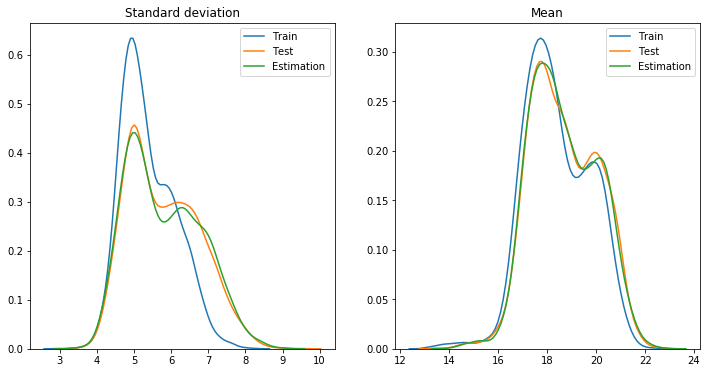

In [20]:
import seaborn as sns

fig, ax = plt.subplots(1,2, figsize = (12,6))

sns.distplot(UP_TR_SD, hist = False, label = 'Train', ax = ax[0])
sns.distplot(UP_TE_SD, hist = False, label = 'Test', ax = ax[0])
sns.distplot(UP_EST_SD, hist = False, label = 'Estimation', ax = ax[0])
ax[0].set_title('Standard deviation')

sns.distplot(UP_TR_MEAN, hist = False, label = 'Train', ax = ax[1])
sns.distplot(UP_TE_MEAN, hist = False, label = 'Test', ax = ax[1])
sns.distplot(UP_EST_MEAN, hist = False, label = 'Estimation', ax = ax[1])
ax[1].set_title('Mean')

In [21]:
np.mean(UP_TR_SD), np.mean(UP_EST_SD), np.mean(UP_TE_SD)

(5.390056135677196, 5.807638799505563, 5.795911524792436)